# CHIRPS-GEFS

Process CHIRPS-GEFS

In [3]:
%load_ext jupyter_black
%load_ext autoreload
%autoreload 2

In [4]:
import pandas as pd
import xarray as xr
import ocha_stratus as stratus
from sqlalchemy import text
from tqdm.auto import tqdm
from azure.core.exceptions import ResourceNotFoundError

from src.datasources.chirps_gefs import ChirpsGefsConfig, ChirpsGefsLoader
from src.datasources import codab
from src.constants import *
from src.utils.database import create_chirps_gefs_table

All imports successful!


In [5]:
TABLE_NAME = f'{PROJECT_PREFIX.replace("-", "_")}_chirps_gefs'

In [6]:
TABLE_NAME

'ds_aa_cub_hurricanes_chirps_gefs'

In [7]:
# create projects schema
# try:
#     with stratus.get_engine("dev", write=True).begin() as conn:
#         conn.execute(text(f"CREATE SCHEMA IF NOT EXISTS {SCHEMA_NAME}"))
# except Exception as e:
#     print("Schema creation failed:", e)

In [8]:
# create_chirps_gefs_table(TABLE_NAME, stratus.get_engine("dev", write=True))

In [9]:
adm0 = codab.load_codab_from_blob()

<Axes: >

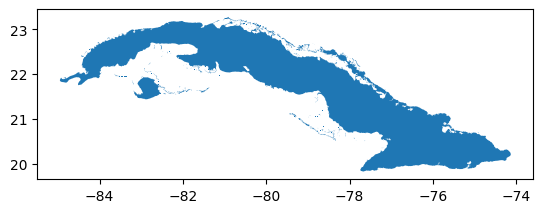

In [10]:
adm0.plot()

In [11]:
config = ChirpsGefsConfig(geometry=adm0, region_name="databricks_run")
loader = ChirpsGefsLoader(config)

In [12]:
query = f"""
SELECT issued_date, COUNT(*) AS n_entries
FROM projects.{TABLE_NAME}
GROUP BY issued_date
ORDER BY issued_date;
"""

df_existing_dates = pd.read_sql(
    query, stratus.get_engine("dev"), parse_dates="issued_date"
)

In [13]:
df_existing_dates

,issued_date,n_entries
0,2000-01-01,96
1,2000-01-02,96
2,2000-01-03,96
3,2000-01-04,96
4,2000-01-05,96
...,...,...
4206,2011-07-11,96
4207,2011-07-12,96
4208,2011-07-13,96
4209,2011-07-14,96


In [14]:
# check complete dates - we have to do this because some dates might not have all the stats
df_complete_dates = df_existing_dates[
    df_existing_dates["n_entries"] == df_existing_dates["n_entries"].max()
]

In [15]:
df_complete_dates

,issued_date,n_entries
0,2000-01-01,96
1,2000-01-02,96
2,2000-01-03,96
3,2000-01-04,96
4,2000-01-05,96
...,...,...
4205,2011-07-10,96
4206,2011-07-11,96
4207,2011-07-12,96
4208,2011-07-13,96


In [16]:
def write_to_db(df_out):
    df_out.to_sql(
        name=TABLE_NAME,
        con=stratus.get_engine("dev", write=True),
        schema="projects",
        if_exists="append",
        method=stratus.postgres_upsert,
        index=False,
    )

In [17]:
quantiles = [0.5, 0.8, 0.9, 0.95, 0.99]

In [ ]:
start_date = "2000-01-01"
end_date = "2024-12-31"

full_date_range = pd.date_range(start=start_date, end=end_date, freq="D")

missing_date_range = full_date_range[
    ~full_date_range.isin(df_complete_dates["issued_date"].to_list())
]

print("processing for dates:")
display(missing_date_range)

verbose = False

for issue_date in tqdm(missing_date_range):
    das_i = []
    for leadtime in range(16):
        valid_date = issue_date + pd.Timedelta(days=leadtime)
        try:
            da_in = loader.load_raster(issue_date, valid_date)
            da_in["valid_date"] = valid_date
            das_i.append(da_in)
        except ResourceNotFoundError as e:
            if verbose:
                print(f"{e} for {issue_date} {valid_date}")

    if das_i:
        da_i = xr.concat(das_i, dim="valid_date")
        da_i_clip = da_i.rio.clip(adm0.geometry, all_touched=True)
        da_rolling2 = da_i_clip.rolling(valid_date=2).sum()
        for quantile in quantiles:
            da_quantile_threshs = da_rolling2.quantile(
                quantile, dim=["x", "y"]
            )
            df_out = (
                da_quantile_threshs.to_dataframe("value")
                .reset_index()
                .drop(columns="quantile")
            )
            df_out["variable"] = f"q{quantile*100:.0f}"
            df_out["issued_date"] = issue_date
            write_to_db(df_out)
        da_means = da_rolling2.mean(dim=["x", "y"])
        df_out = (
            da_means.to_dataframe("value")
            .reset_index()
            .drop(columns="spatial_ref")
        )
        df_out["variable"] = "mean"
        df_out["issued_date"] = issue_date
        write_to_db(df_out)
    else:
        if verbose:
            print(f"no files for issue_date {issue_date}")

processing for dates:


DatetimeIndex(['2000-02-29', '2004-02-29', '2008-02-29', '2011-07-15',
               '2011-07-16', '2011-07-17', '2011-07-18', '2011-07-19',
               '2011-07-20', '2011-07-21',
               ...
               '2024-12-22', '2024-12-23', '2024-12-24', '2024-12-25',
               '2024-12-26', '2024-12-27', '2024-12-28', '2024-12-29',
               '2024-12-30', '2024-12-31'],
              dtype='datetime64[ns]', length=4922, freq=None)

  0%|          | 0/4922 [00:00<?, ?it/s]

/Users/tdowning/.pyenv/versions/ds-aa-cub-hurricanes/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:1620: RuntimeWarning: All-NaN slice encountered
  return fnb._ureduce(a,
/Users/tdowning/.pyenv/versions/ds-aa-cub-hurricanes/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:1620: RuntimeWarning: All-NaN slice encountered
  return fnb._ureduce(a,
/Users/tdowning/.pyenv/versions/ds-aa-cub-hurricanes/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:1620: RuntimeWarning: All-NaN slice encountered
  return fnb._ureduce(a,
/Users/tdowning/.pyenv/versions/ds-aa-cub-hurricanes/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:1620: RuntimeWarning: All-NaN slice encountered
  return fnb._ureduce(a,
/Users/tdowning/.pyenv/versions/ds-aa-cub-hurricanes/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:1620: RuntimeWarning: All-NaN slice encountered
  return fnb._ureduce(a,
/Users/tdowning/.pyenv/versions/ds-aa-cub-hurricanes/lib/python3.